# Video Actor Synchroncy and Causality (VASC)
## RAEng: Measuring Responsive Caregiving Project
### Caspar Addyman, 2020
### https://github.com/infantlab/VASC

# Step 2: Reorganise the OpenPose JSON wire frame data

This script uses output from [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) human figure recognition neural network to create labeled wireframes for each figure in each frame of a video. 


The `write_json flag` saves the people pose data using a custom JSON writer. Each JSON file has a set of coordinates and confidence scores for each person identified in the frame. For a given person there is:

> An array pose_keypoints_2d containing the body part locations and detection confidence formatted as x1,y1,c1,x2,y2,c2,.... The coordinates x and y can be normalized to the range [0,1], [-1,1], [0, source size], [0, output size], etc., depending on the flag keypoint_scale (see flag for more information), while c is the confidence score in the range [0,1].

<img src="keypoints_pose_25.png" alt="BODY-25 mapping" width="240"/>

#### Step 2.0 - import modules and initialise variables

In [1]:
import os
import math
import glob
import json
import numpy as np
import cv2  #computervision toolkit
import pandas as pd
from matplotlib import pyplot as plt

import vasc #a module of our own functions

#turn on debugging
%pdb on

Automatic pdb calling has been turned ON


In [17]:
# OpenPose has two main body models COCO with 18 points and BODY-25 with 25. 
# The default (and better model) is BODY-25. Here we provide the labelling for
# all the points and their relationships to enable us to redraw the wireframes.
#info founnd in https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/src/openpose/pose/poseParameters.cpp

nPoints =25
# what body part is that?
keypointsMapping = {0:  "Nose",
                    1:  "Neck",
                    2:  "RShoulder",
                    3:  "RElbow",
                    4:  "RWrist",
                    5:  "LShoulder",
                    6:  "LElbow",
                    7:  "LWrist",
                    8:  "MidHip",
                    9:  "RHip",
                    10: "RKnee",    
                    11: "RAnkle",
                    12: "LHip",  
                    13: "LKnee",            
                    14: "LAnkle",
                    15: "REye",     
                    16: "LEye",
                    17: "REar",
                    18: "LEar",
                    19: "LBigToe",
                    20: "LSmallToe",
                    21: "LHeel",
                    22: "RBigToe",
                    23: "RSmallToe",
                    24: "RHeel",
                    25: "Background"}

#what are coordinates of each point
POINT_COORDS = [[ 0, 1], [14,15], [22,23], [16,17], [18,19], [24,25], [26,27], 
                [ 6, 7], [ 2, 3], [ 4, 5], [ 8, 9], [10,11], [12,13], [30,31], 
                [32,33], [36,37], [34,35], [38,39], [20,21], [28,29], [40,41], 
                [42,43], [44,45], [46,47], [48,49], [50,51]]

#Which pairs of points are connected in the wireframe?
POSE_PAIRS = [[ 1, 8], [ 1, 2], [ 1, 5], [ 2, 3], [ 3, 4], [ 5, 6], [ 6, 7], 
              [ 8, 9], [ 9,10], [10,11], [ 8,12], [12,13], [13,14], [ 1, 0], 
              [ 0,15], [15,17], [ 0,16], [16,18], [14,19],
              [19,20], [14,21], [11,22], [22,23], [11,24]]
              # [ 2,17], [ 5,18]

#What color shall we paint each point.
pointcolors =  [[255,     0,    85],
                [255,     0,     0],
                [255,    85,     0],
                [255,   170,     0],
                [255,   255,     0],
                [170,   255,     0],
                [ 85,   255,     0],
                [  0,   255,     0],
                [255,     0,     0],
                [  0,   255,    85],
                [  0,   255,   170],
                [  0,   255,   255],
                [  0,   170,   255],
                [  0,    85,   255],
                [  0,     0,   255],
                [255,     0,   170],
                [170,     0,   255],
                [255,     0,   255],
                [ 85,     0,   255],
                [  0,     0,   255],
                [  0,     0,   255],
                [  0,     0,   255],
                [  0,   255,   255],
                [  0,   255,   255],
                [  0,   255,   255]]


#will colour each person 0:9 a different colour to help us keep track
personcolors = [ [255,0,0], [0,255,0], [0,0,255],[0,255,255], [255,0,255], [255,255,0],[128,255,255], [255,128,255], [255,255,128],[0,0,0]]

#useful to have the indices of the x & y coords and the confidence scores 
#recall that we get them in the order [x0,y0,c0,x1,y1,c1,x2,etc]
xs = [0+3*i for i in range(nPoints)]
ys = [1+3*i for i in range(nPoints)]
cs = [2+3*i for i in range(nPoints)]

#### Step 2.1 Where are the JSON files?

This routine needs to know where to find the processed videos and what are the base names. These are listed in the `videos.json` file we created.

In [3]:
# where's the project folder?

jupwd =  os.getcwd() + "\\"
projectpath = os.getcwd() + "\\..\\lookit\\"

# locations of videos and output
videos_in = projectpath 
videos_out_openpose   = projectpath + "\\out\\openpose"
videos_out_timeseries = projectpath + "\\out\\timeseries"
videos_out_analyses   = projectpath + "\\out\\analyses"

print(videos_in)
print(videos_out_openpose)
print(videos_out_timeseries)
print(videos_out_analyses)

C:\Users\cas\OneDrive - Goldsmiths College\Projects\Measuring Responsive Caregiving\VASC\..\lookit\
C:\Users\cas\OneDrive - Goldsmiths College\Projects\Measuring Responsive Caregiving\VASC\..\lookit\\out\openpose
C:\Users\cas\OneDrive - Goldsmiths College\Projects\Measuring Responsive Caregiving\VASC\..\lookit\\out\timeseries
C:\Users\cas\OneDrive - Goldsmiths College\Projects\Measuring Responsive Caregiving\VASC\..\lookit\\out\analyses


In [4]:
#retrieve the list of base names of processed videos.
with open(videos_out_openpose + '\\videos.json') as json_file:
    videos = json.load(json_file)

In [5]:
for vid in videos:  
    print(vid)
    print(videos[vid])

lookit.01
{'fullname': 'lookit.01.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:38:00.675606'}}
lookit.02
{'fullname': 'lookit.02.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:38:13.844165'}}
lookit.03
{'fullname': 'lookit.03.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:38:27.170616'}}
lookit.04
{'fullname': 'lookit.04.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:38:52.077285'}}
lookit.05
{'fullname': 'lookit.05.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:39:19.118261'}}
lookit.06
{'fullname': 'lookit.06.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:39:36.051385'}}
lookit.07
{'fullname': 'lookit.07.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:39:55.776891'}}
lookit.08
{'fullname': 'lookit.08.mp4', 'format': '.mp4', 'openpose': {'exitcode': 0, 'when': '2020-01-25T15:40:12.183380'}}


### Step 2.2 Extract all the numeric data from the json files

We loop through the list of names in `videos` and search for all json files associated with that name. We then extract all the coordinates and confidence scores for all identified people in each frame and store them in one big multidimensional padded array.

```
1st dimension - number of videos
2nd dimension - max nummber of frames
3rd dimension - max number of people
4th dimension - number of values (per person) output by openpose
```

For example, if we had the following videos 

```
video1 - 200 frames  - 3 people (max) 
video2 - 203 frames  - 2 people (max) 
video3 - 219 frames  - 4 people (max) 
```

then we'd create a `3 x 219 x 4 x 75` array.

In [6]:
# We will first combine all the data into one giant numpy array. Then we will use this for everything that comes after. 
# such as normalising.. confirming that person 1 is same individal all way through etc.

nvideos = len(videos)
maxframes = 0
maxpeople = 10 #maximum people we might expect (large upper bound)
ncoords = 75 #the length of the array coming back from openpose x,y coords of each point plus pafs

for vid in videos:    
    #use glob to get all the individual json files.
    alljson = glob.glob(videos_out_openpose + "\\" + vid + "*.json")
    nframes = len(alljson)
    print("Video", vid, "has {0} frames.".format(nframes))
    videos[vid]["frames"] = nframes
    maxframes = max(maxframes,nframes)
    
keypoints_array = np.zeros([nvideos,maxframes,maxpeople,ncoords]) #big array to hold all the numbers
print("Initialise numpy array of size", keypoints_array.shape)

npeople = np.zeros(maxframes)  #how many people detected per frame?


Video lookit.01 has 162 frames.
Video lookit.02 has 161 frames.
Video lookit.03 has 164 frames.
Video lookit.04 has 379 frames.
Video lookit.05 has 412 frames.
Video lookit.06 has 229 frames.
Video lookit.07 has 282 frames.
Video lookit.08 has 222 frames.
Video lookit.09 has 245 frames.
Video lookit.10 has 259 frames.
Initialise numpy array of size (10, 412, 10, 75)


In [7]:
globalmaxpeople =  0
v = 0
for vid in videos:  
    #use glob to get all the individual json files.
    alljson = glob.glob(videos_out_openpose + "\\" + vid + "*.json") 
    i = 0
    for frame in alljson:
        with open(frame, "r") as read_file:
            data = json.load(read_file)
            j = 0
            for p in data["people"]:
                keypoints = p["pose_keypoints_2d"]  
                keypoints_array[v,i,j,:]=keypoints
                j += 1
            npeople[i] = j
            i += 1
    #end loop for this video
    people = int(max(npeople))
    print("Video", vid, "has {0} people detected.".format(people))
    videos[vid]["maxpeople"] = people
    #how many people did it contain? Is this biggest number so far?
    globalmaxpeople = max(globalmaxpeople, people)
    v += 1
    
#and just like that n videos have been reduced to a big block of people coords.
#we now truncate the array for the maximum of people 

keypoints_array = np.delete(keypoints_array,np.s_[int(globalmaxpeople):],2)

print("keypoints_array has size", keypoints_array.shape)

Video lookit.01 has 4 people detected.
Video lookit.02 has 2 people detected.
Video lookit.03 has 3 people detected.
Video lookit.04 has 3 people detected.
Video lookit.05 has 4 people detected.
Video lookit.06 has 4 people detected.
Video lookit.07 has 3 people detected.
Video lookit.08 has 3 people detected.
Video lookit.09 has 3 people detected.
Video lookit.10 has 3 people detected.
keypoints_array has size (10, 412, 4, 75)


In [8]:
#save the data file. 
#in a compressed format as it has a lot of empty values
np.savez_compressed('allframedata.npz', keypoints_array)

In [9]:
#Let's pic a frame a draw the wireframe skeleton
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

### Step 2.3 Identify the actors

We now have an numpy array called `keypoints_array` containing all the openpose numbers for all videos. Now we need to do some cleaning of the data. We will do this in four substages.

1. Tag the first and last frames of interest. 
2. Tag the adult & infant in first frame of interest. So both individuals should be in first frame.
3. Try to tag then in subsequent frames.
4. Exclude other detected people (3rd parties & false positives)

For most steps we will let computer make a suggestion which human can accept or override. 

### Step 2.3.1: Where does the interesting data start?

For many videos, the period of interest might start (and end) some time into the video.  
TODO  - We wiil give the user the opportunity to set these.


In [10]:
#let's loop through the processed list and set and startframe and endframe for each video
# for the moment we'll just use the full video.

for vid in videos:
    videos[vid]["start"] = 50
    videos[vid]["end"] = videos[vid]["frames"] 

### Step 2.3.2: Tag the actors of interest

Now it starts to get interesting! We want to know which person is the adult and which is the infant in the first frame. 

In [14]:
def getframeimage(videopath,framenumber):
    cap = cv2.VideoCapture(videopath)
    cap.set(cv2.CAP_PROP_POS_FRAMES,framenumber) # Where frame_no is the frame you want
    ret, frame = cap.read() # Read the frame
    # When everything done, release the capture
    cap.release()
    if ret:
        return frame
    else:
        #TODO - what do we do now?
        return False

    
def drawPoints(frame, framekeypoints, people):
    for p in range(people):
        personkeypoints = framekeypoints[p,:]
        for i in range(nPoints):
            coords = vasc.getkeypointcoord(personkeypoints,i)
            if sum(coords) > 0:
                cv2.circle(frame,coords, 2, pointcolors[i], -1, cv2.LINE_AA)

def drawLines(frame, framekeypoints, people):
    for p in range(people):
        personkeypoints = framekeypoints[p,:]
        for i in range(len(POSE_PAIRS)):
            l = POSE_PAIRS[i]
            A = vasc.getkeypointcoord(personkeypoints,l[0])
            B = vasc.getkeypointcoord(personkeypoints,l[1])
            if sum(A) > 0 and sum(B) > 0:
                cv2.line(frame, (A[0], A[1]), (B[0], B[1]), pointcolors[i], 2, cv2.LINE_AA)    

def drawBodyCG(frame, framekeypoints, people):
    font = cv2.FONT_HERSHEY_SIMPLEX   
    fontScale = 1
    for p in range(people):
        personkeypoints = framekeypoints[p,:]
        for i in range(nPoints):
            avx = vasc.averagePoint(personkeypoints,xs)
            avy = vasc.averagePoint(personkeypoints,ys)

            cgloc  = tuple((int(avx),int(avy)))
            cv2.circle(frame,cgloc, 2, [0,0,0], -1, cv2.LINE_AA)   

            txtloc = tuple((int(avx) - 50,int(avy) - 30))
            cv2.putText(frame, str(p), txtloc, font, fontScale, personcolors[p])


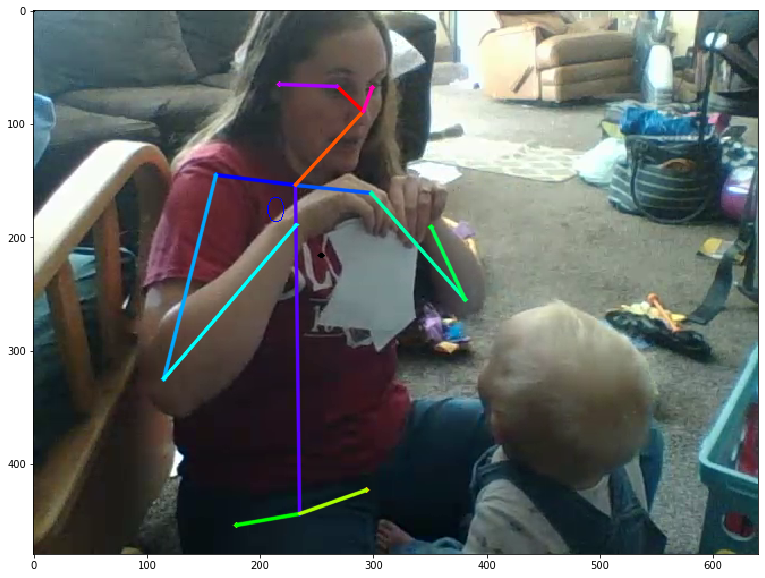

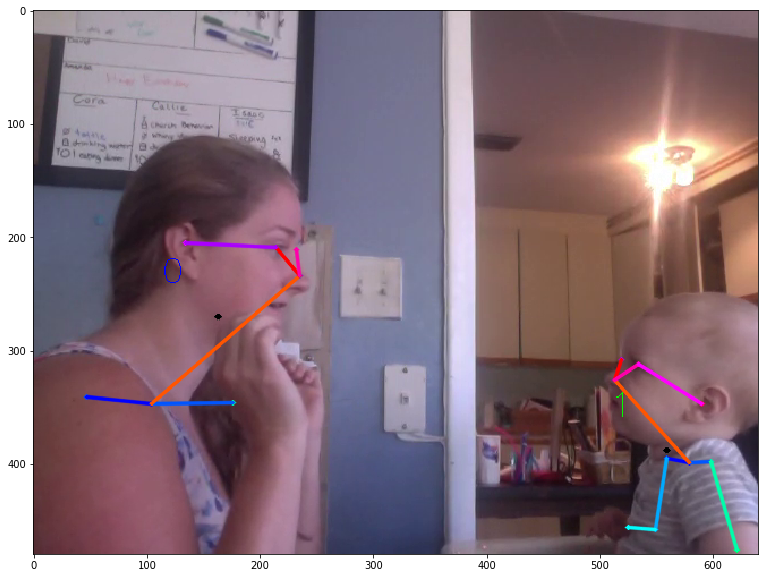

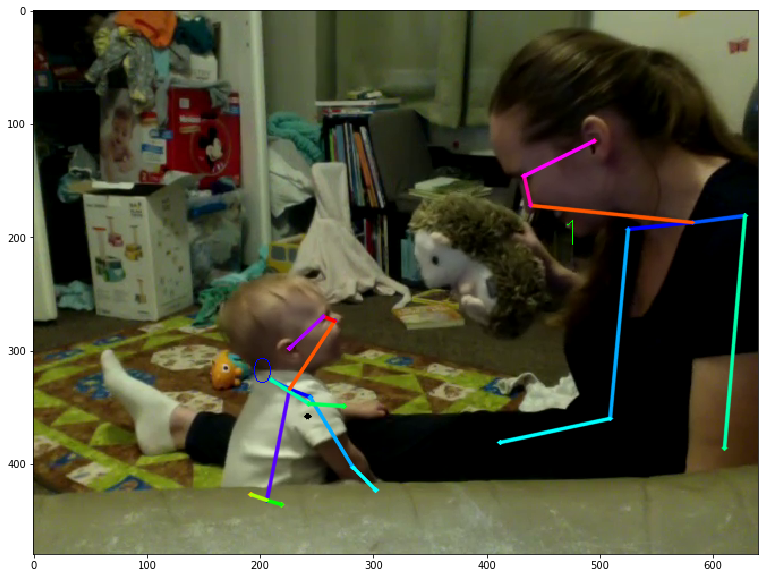

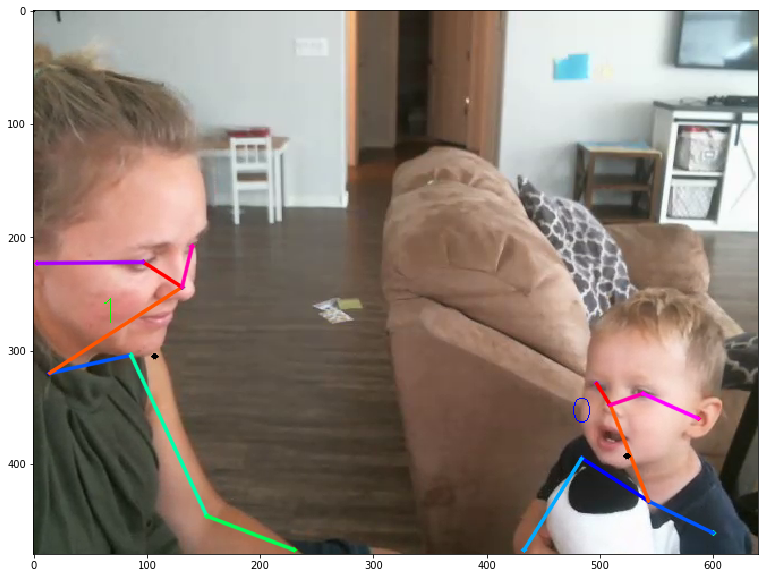

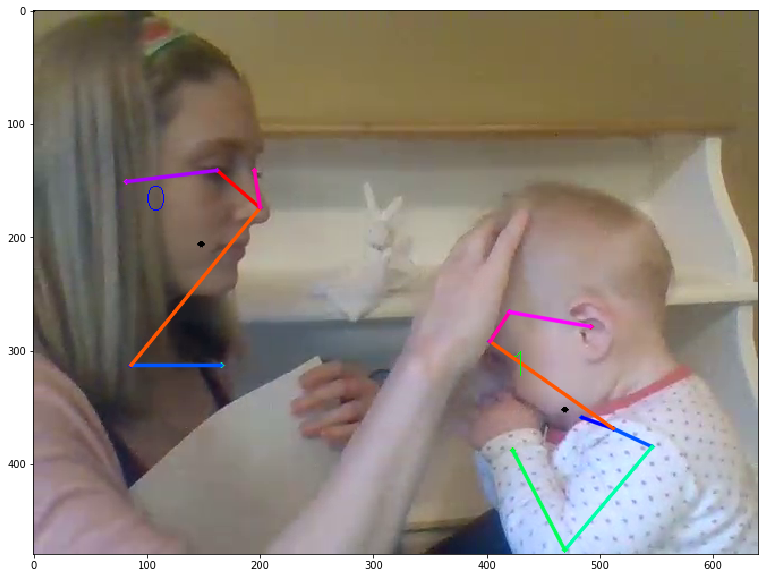

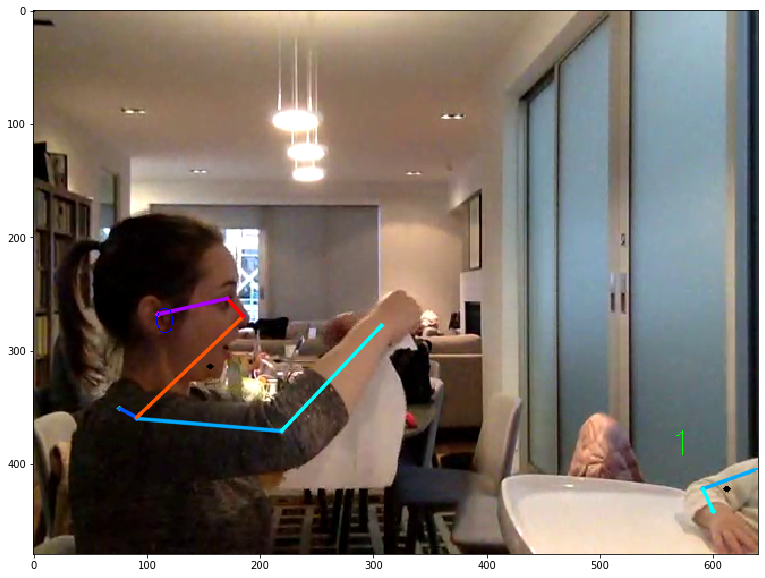

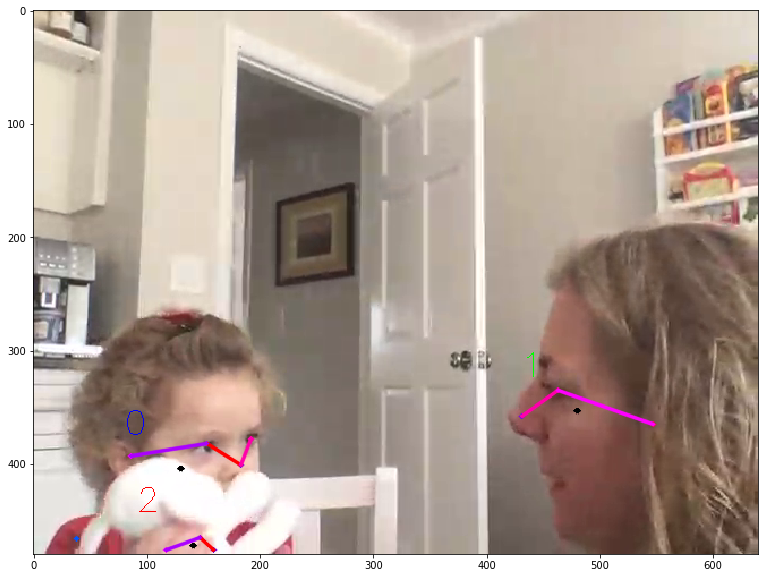

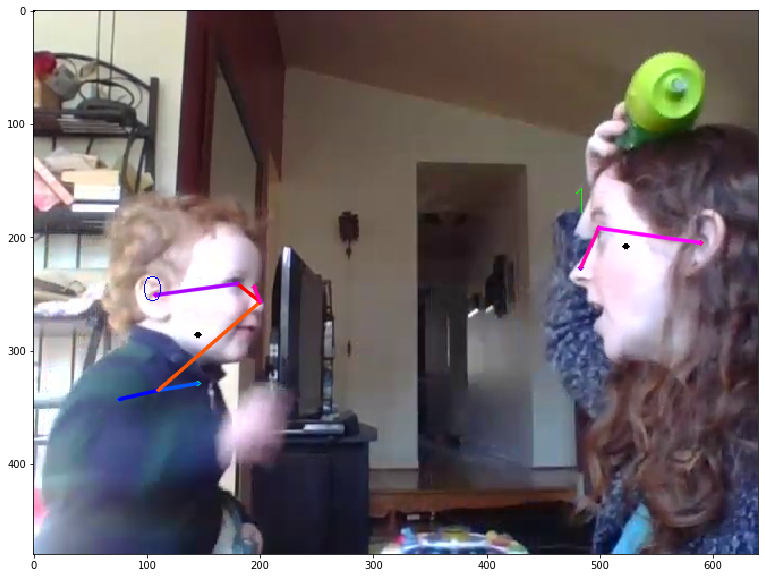

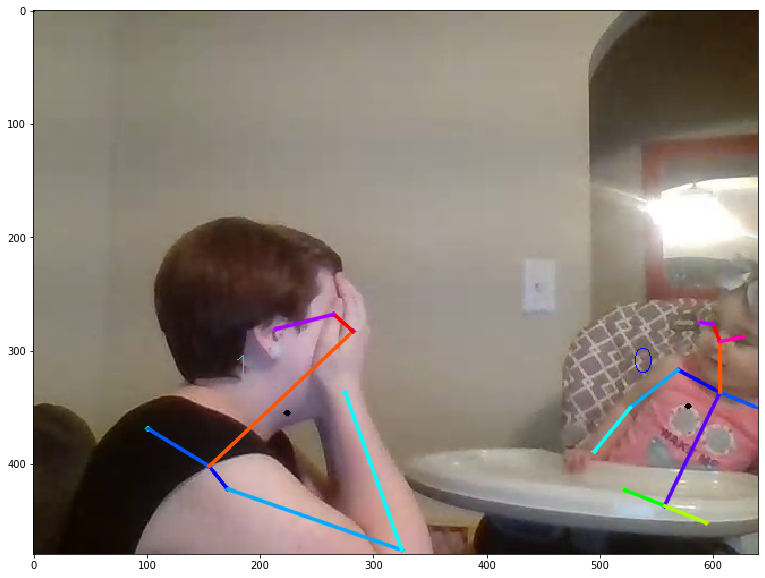

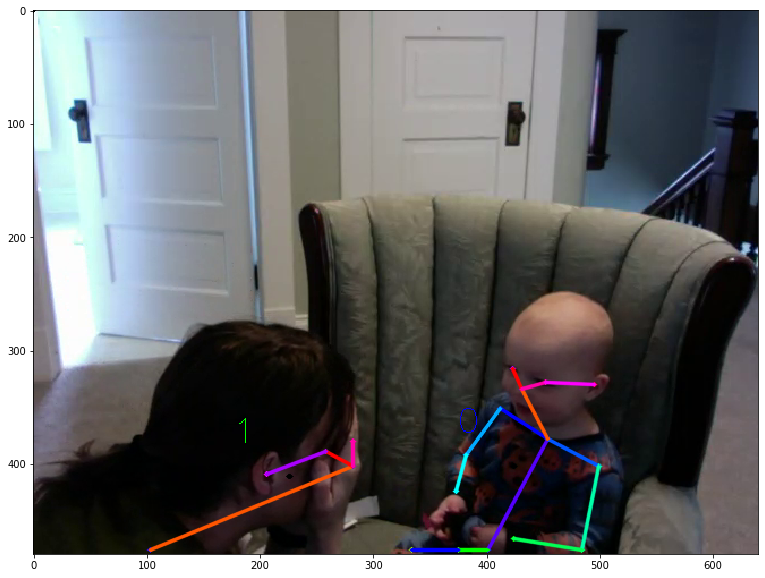

In [18]:
import ipywidgets as widgets

v= 0
for vid in videos:
    vidpath = videos_in + "\\" + videos[vid]["fullname"]
    start = videos[vid]["start"] 
    frame = getframeimage(vidpath,50) 
    drawPoints(frame,keypoints_array[v,start,:,:],videos[vid]["maxpeople"])
    drawLines(frame,keypoints_array[v,start,:,:],videos[vid]["maxpeople"])
    drawBodyCG(frame,keypoints_array[v,start,:,:],videos[vid]["maxpeople"])
    plt.figure(figsize=[14,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    #we've drawn the figure now ask user to tell us who is adult & who is baby 
    v += 1
    print()

### Step 2.3.3: Try to track actors over time

### Step 2.3.4: Exclude other people

### Step 2.4: Clean and smooth the data

There are

### Step 2.5: Derive some data

We could calculate the mean position of each person (the average of all their detected points). It is also useful to have mean head position.  

In [ ]:
cap = cv2.VideoCapture("attachment_avoidant_AGRT6VjnTm8_360p.mp4")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1

print(total_frames)

framenumber = thisframe
cap.set(cv2.CAP_PROP_POS_FRAMES,framenumber) # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
#cv2.imwrite("frame%#05d.jpg" % (framenumber+1), frame)

plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
print(npeople[thisframe])
print(keypoints_array[thisframe,thisperson,:])



In [ ]:
plt.clf() 



    

plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])


In [ ]:
npeople[thisframe]

In [ ]:
def averagePoint(keypointList,indices):

In [ ]:





plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [ ]:
with open("attachment_avoidant_AGRT6VjnTm8_360p_000000000181_keypoints.json", "r") as read_file:
    data = json.load(read_file)
    

detected_keypoints = []
keypoints_array = np.zeros((1,18*3))
keypoint_id = 0
threshold = 0.1

for p in data["people"]:
    keypoints = p["pose_keypoints_2d"]        
    keypoint_id = 0
    keypoints_with_id = []
    keypoints_array = keypoints
    for part in range(nPoints):
        thisone =  {keypointsMapping[part] : {"x" : keypoints[keypoint_id], "y" : keypoints[keypoint_id + 1], "conf" : keypoints[keypoint_id + 2]}}
        keypoints_with_id.append(thisone)
        keypoint_id += 3
    #print(keypoints_with_id)
    print(keypoints_array)

numpy.save("al")

In [ ]:
cap = cv2.VideoCapture("attachment_avoidant_AGRT6VjnTm8_360p.mp4")

while(cap.isOpened()):
    ret, frame = cap.read()
    cv2.imshow('frame',frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break


# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:


cap = cv2.VideoCapture("attachment_avoidant_AGRT6VjnTm8_360p.mp4")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1

print(total_frames)

framenumber = 1000
cap.set(cv2.CAP_PROP_POS_FRAMES,framenumber) # Where frame_no is the frame you want
ret, frame = cap.read() # Read the frame
#cv2.imwrite("frame%#05d.jpg" % (framenumber+1), frame)

cv2.imshow('babies', frame)
cv2.waitKey(0)

In [ ]:
# cv2.imshow('babies', frame)

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_array = np.vstack([keypoints_array, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
video_to_frames("attachment_avoidant_AGRT6VjnTm8_360p.mp4", "./frames/")